<a href="https://colab.research.google.com/github/doumoh/RIS_aided_communication/blob/main/Neural_Receiver_for_OFDM_SIMO___.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip uninstall -y sionna tensorflow tensorflow-probability numpy
!pip install sionna==0.19 tensorflow tensorflow-probability numpy --upgrade
!pip uninstall -y mitsuba
!pip install mitsuba==3.5.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of ipywidgets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of ipywidgets to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 16.7 MB/s eta 

Found existing installation: mitsuba 3.6.4
Uninstalling mitsuba-3.6.4:
  Successfully uninstalled mitsuba-3.6.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: drjit
    Found existing installation: drjit 1.0.5
    Uninstalling drjit-1.0.5:
      Successfully uninstalled drjit-1.0.5


In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna==0.19")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42 # Set seed for reproducible random number generation
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.channel.tr38901 import Antenna, AntennaArray
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.mimo import StreamManagement
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, normalize, Camera
from sionna import PI
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Blender Scene/rxx.xml'

Mounted at /content/drive


In [97]:
# Load scene
scene = load_scene(file_path)
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="H")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[-4,3,3])

# Add transmitter
scene.add(tx)

width = 8 * scene.wavelength # Width [m] for 16*16 RIS elements
num_rows = num_cols = int(width/(0.5*scene.wavelength))
ris = RIS(name="ris",
          position=[6,-3,2],
          orientation=[PI/2,0,0],
          num_rows=num_rows,
          num_cols=num_cols)

scene.add(ris)

# Create a receiver
rx = Receiver(name="rx",
              position=[3,4.5,3.5],
              orientation=[0,0,0])

# Add receiver
scene.add(rx)


In [98]:
from sionna.rt.solver_paths import SolverPaths # Import SolverPaths to modify the _ris_transition_matrices function
class CustomSolverPaths(SolverPaths):
    def _ris_transition_matrices(self, ris_paths, ris_paths_tmp):
        # Compute scattering coefficients
        sc = [tf.reduce_sum(r(), axis=0) for r in self._scene.ris.values()]
        sc = tf.concat(sc, axis=0)
        sc = sc[tf.newaxis, tf.newaxis, ...]


        # Coefficient calculation
        coef = tf.cast(4 * PI, self._rdtype)
        coef /= tf.reduce_prod(ris_paths_tmp.distances, axis=0)
        coef *= tf.cast(tf.sqrt(tx.power_dbm * 0.001 * 120 * PI * 2 * 66), self._rdtype)
        coef = tf.complex(coef, tf.cast(0, self._rdtype))

        # Differentiable phase decision: use magnitude of imag part
        imag_part = tf.math.imag(sc)

        # Sharpen sigmoid to approximate a step function: large scaling factor
        sharpness = 100000000.0  # Higher value = closer to hard decision
        phase_weight = tf.sigmoid(sharpness * imag_part)  # Step at imag_part = 0

        # Now interpolate between 0° for real (imag == 0) and 165° for complex (non-zero imag)
        phase_deg = phase_weight * 2 * 165.0


        # Convert to radians and cast
        phase_rad = phase_deg * (np.pi / 180.0)
        phase_rad = tf.cast(phase_rad, self._rdtype)


        # Compute complex phase rotation
        sigma_eff_value = 0.001  # Scalar value
        sqrt_sigma = tf.sqrt(tf.cast(sigma_eff_value, self._rdtype))
        sqrt_sigma = tf.complex(sqrt_sigma, tf.cast(0, self._rdtype))  # Ensure sqrt_sigma is complex
        sigma_phi_matrix = sqrt_sigma * tf.exp(
            tf.complex(0.0, phase_rad)  # Ensure exp result is complex
        )

        # Apply coefficient modification with masking
        coef *= sigma_phi_matrix
        coef = tf.where(ris_paths.mask, coef, tf.cast(0, coef.dtype))

        # Create polarization-preserving transition matrices
        coef = coef[..., tf.newaxis, tf.newaxis]
        ris_mat_t = coef * tf.eye(2, batch_shape=[1, 1, 1], dtype=self._dtype)

        return ris_mat_t
scene._solver_paths = CustomSolverPaths(scene) # Replace to custom SolverPaths


In [99]:
# SNR range for evaluation and training
ebno_db_min = -5.0
ebno_db_max = 10.0

## OFDM configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers
num_ofdm_symbols = 14 # Number of OFDM symbols
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
#pilot_ofdm_symbol_indices = [2] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain.

## Modulation and coding configuration
num_bits_per_symbol = 2 # QPSK
coderate = 0.5 # Coderate for LDPC code

## Neural receiver configuration
num_conv_channels = 12 # Number of convolutional channels for the convolutional layers forming the neural receiver

## Training configuration
training_batch_size = 64 # Training batch size
model_weights_path = "neural_receiver_weights" # Location to save the neural receiver weights once training is done
stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter
resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)
# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate)

In [110]:
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)

a, tau = paths.cir()
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True)

In [108]:
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)
batch_size = 64
ebno_db = tf.fill([batch_size], -5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
c = binary_source([batch_size, 1, 1, n])
x = mapper(c)
x_rg = rg_mapper(x)
channel = ApplyOFDMChannel(add_awgn=True)

In [109]:
def clean_subcarriers(ofdm_symbol, dc_null=True, guard_left=5, guard_right=6):
    # Remove guards
    active = ofdm_symbol[guard_left:-guard_right]
    if dc_null:
        # Remove DC (middle subcarrier)
        dc_idx = (len(active)) // 2
        active = tf.concat([active[:dc_idx], active[dc_idx+1:]], axis=0)
    return active
# Keep track of best loss and corresponding phase configuration
best_loss = np.inf
# Create trainable variables for phase (continuous)
phase_var = tf.Variable(tf.zeros_like(ris.phase_profile.values), trainable=True)
best_phase_config = tf.Variable(tf.zeros_like(ris.phase_profile.values), trainable=False)
optimizer = tf.keras.optimizers.Adam()
@tf.custom_gradient
def binarize_phase(x):
    pi = tf.constant(np.pi, dtype=tf.float32)
    binary = tf.where(x > 0, pi, 0.0)         # Anything > 0 --> pi else 0
    def grad(dy):
        return dy * tf.cast(tf.logical_and(x > -1.0, x < 1.0), tf.float32) # Accept gradient between -1.5 and 1.5 ,other set to zero (no update)
    return binary, grad

def to_db(x):
    return 10*tf.math.log(x)/tf.math.log(10.)
# Training step
def train_step():
    global best_loss, best_phase_config

    with tf.GradientTape() as tape:
        # Apply binarized and differentiable phase
        bin_phase = binarize_phase(phase_var)

        # Apply binarized phase to RIS
        ris.phase_profile.values = bin_phase

        # Compute channel response and output
        paths = scene.compute_paths(max_depth=5, num_samples=1e6)
        a, tau = paths.cir()
        frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)
        h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)
        y = channel([x_rg, h_freq, no])

        # Extract pilots and compute loss
        y_pilots_sym2 = y[0, 0, 0, 2]  # shape: (128,)
        active_sym2 = clean_subcarriers(y_pilots_sym2)
        energy_per_symbol2 = tf.abs(active_sym2) ** 2
        loss1 = tf.reduce_sum(energy_per_symbol2)
        print(loss1)
        # Compute loss on pilot energy
        y_pilots_sym11 = y[0, 0, 0, 11]
        active_sym11 = clean_subcarriers(y_pilots_sym11)
        energy_per_symbol11 = tf.abs(active_sym11) ** 2
        loss2 = tf.reduce_sum(energy_per_symbol11)
        print(loss2)
        loss = - (loss1 + loss2)

    # Check if this is a better phase config (i.e., lower loss)
    if loss < best_loss:
        best_loss = loss
        best_phase_config.assign(phase_var)  # Save current phase_var
       # ris.phase_profile.values = phase_var
        grads = tape.gradient(loss, [phase_var])
        optimizer.apply_gradients(zip(grads, [phase_var]))
        print(f" Accepted update: Loss = {loss.numpy():.2f}")
    else:
        phase_var.assign(best_phase_config)  # Revert to best
        print(f" Rejected update: Loss = {loss.numpy():.2f} (Best = {best_loss.numpy():.2f})")

    return loss
num_iterations = 15
for i in range(num_iterations):
    loss = train_step()
    print(f"Iteration {i}: Loss = {loss.numpy():.2f} ")


tf.Tensor(484.9344, shape=(), dtype=float32)
tf.Tensor(427.24667, shape=(), dtype=float32)
 Accepted update: Loss = -912.18
Iteration 0: Loss = -912.18 
tf.Tensor(511.01337, shape=(), dtype=float32)
tf.Tensor(503.1158, shape=(), dtype=float32)
 Accepted update: Loss = -1014.13
Iteration 1: Loss = -1014.13 
tf.Tensor(519.91455, shape=(), dtype=float32)
tf.Tensor(522.62726, shape=(), dtype=float32)
 Accepted update: Loss = -1042.54
Iteration 2: Loss = -1042.54 
tf.Tensor(516.7496, shape=(), dtype=float32)
tf.Tensor(437.499, shape=(), dtype=float32)
 Rejected update: Loss = -954.25 (Best = -1042.54)
Iteration 3: Loss = -954.25 
tf.Tensor(446.425, shape=(), dtype=float32)
tf.Tensor(470.58264, shape=(), dtype=float32)
 Rejected update: Loss = -917.01 (Best = -1042.54)
Iteration 4: Loss = -917.01 
tf.Tensor(468.29062, shape=(), dtype=float32)
tf.Tensor(517.182, shape=(), dtype=float32)
 Rejected update: Loss = -985.47 (Best = -1042.54)
Iteration 5: Loss = -985.47 
tf.Tensor(465.93527, shape=

In [76]:
class ResidualBlock(Layer):

    def build(self, input_shape):

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[2,2],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[2,2],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z)
        z = z + inputs

        return z

class NeuralReceiver(Layer):

    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[2,2],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[2,2],
                                   padding='same',
                                   activation=None)

    def call(self, inputs):
        y, no = inputs

        # Feeding the noise power in log10 scale
        no = log10(no)
        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        return z

In [77]:
class E2ESystem(Model):


    def __init__(self, system, training=False):
        super().__init__()
        self._system = system
        self._training = training

        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)
        ######################################
        ## Channel
        self._channel = ApplyOFDMChannel(add_awgn=True)
        ######################################
        ## Receiver
        if "baseline" in system:
            if system == 'baseline-perfect-csi':  # Perfect CSI
                self._removed_null_subc = RemoveNulledSubcarriers(resource_grid)
            elif system == 'baseline-ls-estimation':  # LS estimation
                self._ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
            # Components required by both baselines
            self._lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager)
            self._demapper = Demapper("app", "qam", num_bits_per_symbol)

        elif system == "neural-receiver":  # Neural receiver
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)  # Used to extract data-carrying resource elements
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
    @tf.function
    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        no_ = expand_to_rank(no, tf.rank(x_rg))
        # channel
        y   = self._channel([x_rg,h_freq, no_])
        if "baseline" in self._system:
            if self._system == 'baseline-perfect-csi':
                h_hat = self._removed_null_subc(h_freq) # Extract non-null subcarriers
                batch_size = tf.shape(y)[0]  # Or pass batch_size explicitly if available
                # Tile h_hat across the batch dimension
                h_hat = tf.tile(h_hat, [batch_size, 1, 1, 1, 1, 14, 1])
                err_var = 0.0 # No channel estimation error when perfect CSI knowledge is assumed
            elif self._system == 'baseline-ls-estimation':
                h_hat, err_var = self._ls_est([y, no]) # LS channel estimation with nearest-neighbor


            x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no]) # LMMSE equalization
            no_eff_= expand_to_rank(no_eff, tf.rank(x_hat))
            llr = self._demapper([x_hat, no_eff_]) # Demapping
        elif self._system == "neural-receiver":
            # The neural receiver computes LLRs from the frequency domain received symbols and N0
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver([y, no])
            llr = insert_dims(llr, 2, 1) # Reshape the input to fit what the resource grid demapper is expected
            llr = self._rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
            llr = tf.reshape(llr, [batch_size, 1, 1, n]) # Reshape the LLRs to fit what the outer decoder is expected
        if self._training:
            # Compute and return BMD rate (in bit), which is known to be an achievable
            # information rate for BICM systems.
            # Training aims at maximizing the BMD rate
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            return rate
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat # for BER/BLER computation


In [111]:
num_training_iterations = 300 # Number of training iterations
training = True
if training:
    model = E2ESystem('neural-receiver', training=True)

    optimizer = tf.keras.optimizers.Adam()

    for i in range(num_training_iterations):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            rate = model(training_batch_size, ebno_db)
            loss = - rate
            print(loss.numpy())

        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        if i % 100 == 0:
            print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')



0.34134972
0.26139712
0.23212957
0.2929933
0.29277897
0.14155912
0.1429708
0.10957432
0.18412626
0.1586082
0.062215924
0.21503556
0.117060184
0.05015123
0.042672753
0.0181185
0.057634234
0.0318377
0.027900338
0.03261769
0.0724597
-0.025330245
-0.021849394
-0.020255327
-0.042271435
0.07236302
0.05453384
-0.053188205
-0.053871572
0.036516428
-0.03251636
-0.033226192
-0.0763461
-0.076663435
-0.049025297
-0.09246445
-0.09110862
-0.01934737
-0.10817665
-0.08758855
-0.05701989
-0.12102044
-0.124272764
-0.12961304
-0.06924975
-0.11839306
-0.13712221
-0.14564896
-0.09085953
-0.15475088
-0.15609318
-0.16378039
-0.15803677
-0.16376859
-0.15502179
-0.078899205
-0.111242056
-0.19378746
-0.19748783
-0.18409282
-0.20041853
-0.18398833
-0.18555623
-0.1840074
-0.21833557
-0.19896513
-0.18615943
-0.15983796
-0.21445215
-0.16894573
-0.21364164
-0.18970186
-0.16000086
-0.18579155
-0.23348755
-0.28128713
-0.26919472
-0.29044503
-0.28200918
-0.26454055
-0.2811203
-0.24016905
-0.20177454
-0.25118625
-0.3011

In [112]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)
save_weights(model, model_weights_path)
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     1) # Step
# function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
# Dictionary storing the evaluation results
BER = {}

model = E2ESystem('baseline-perfect-csi')
ber,_ = sim_ber(model, ebno_dbs, batch_size=64, num_target_block_errors=100, max_mc_iter=100)
BER['baseline-perfect-csi-OpRIS'] = ber.numpy()

model = E2ESystem('baseline-ls-estimation')
ber,_ = sim_ber(model, ebno_dbs, batch_size=64, num_target_block_errors=100, max_mc_iter=100)
BER['baseline-ls-estimation-OpRIS'] = ber.numpy()

model = E2ESystem('neural-receiver')

# Run one inference to build the layers and loading the weights
model(1, tf.constant(10.0, tf.float32))
with open(model_weights_path, 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)

# Evaluations
ber,_ = sim_ber(model, ebno_dbs, batch_size=64, num_target_block_errors=100, max_mc_iter=100)
BER['neural-receiver-OpRIS'] = ber.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.4955e-01 | 1.0000e+00 |       44463 |      178176 |          128 |         128 |         5.0 |reached target block errors
     -4.0 | 2.1514e-01 | 1.0000e+00 |       38332 |      178176 |          128 |         128 |         1.7 |reached target block errors
     -3.0 | 1.6268e-01 | 1.0000e+00 |       28986 |      178176 |          128 |         128 |         1.7 |reached target block errors
     -2.0 | 1.1219e-02 | 4.1016e-01 |        3998 |      356352 |          105 |         256 |         4.7 |reached target block errors
     -1.0 | 0.0000e+00 | 0.0000e+00 |           0 |     8908800 |            0 |        6400 |        95.6 |reached max iter       

Simulation stopped as no error occurred @ EbNo = -1.0 dB.

EbNo [dB]

In [113]:
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)
#neural_receiver = model_conventional._neural_receiver
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)
channel = ApplyOFDMChannel(add_awgn=True)
batch_size = 64
ebno_db = tf.fill([batch_size], 25.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
## Transmitter
# Generate codewords
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)
# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)
# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)
print("h_freq shape: ", h_freq.shape)
######################################
## Channel
no_ = expand_to_rank(no, tf.rank(x_rg))
print("no shape: ", no.shape)
print("no_ shape: ", no_.shape)
# Apply channel
channel = ApplyOFDMChannel(add_awgn=True)
y = channel([x_rg, h_freq, no])
print("y shape: ", y.shape)
######################################
#_lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager, )
##_removed_null_subc = RemoveNulledSubcarriers(resource_grid)
######################################
## Receiver
_lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager)
_demapper = Demapper("app", "qam", num_bits_per_symbol)
_ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
# The neural receiver computes LLRs from the frequency domain received symbols and N0
#y = tf.squeeze(y, axis=1)
#h_hat = _removed_null_subc(h_freq) # Extract non-null subcarriers
#batch_size = tf.shape(y)[0]  # Or pass batch_size explicitly if available
h_hat, err_var = _ls_est([y, no])
# Tile h_hat across the batch dimension
#h_hat = tf.tile(h_hat, [batch_size, 1, 1, 1, 1, 14, 1])
x_hat, no_eff = _lmmse_equ([y, h_hat, err_var, no]) # LMMSE equalization
no_eff_= expand_to_rank(no_eff, tf.rank(x_hat))
llr = _demapper([x_hat, no_eff_]) # Demapping


bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
bce = tf.reduce_mean(bce)
rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
print(f"Rate: {rate:.2E} bit")

c shape:  (64, 1, 1, 2784)
x shape:  (64, 1, 1, 1392)
x_rg shape:  (64, 1, 1, 14, 128)
h_freq shape:  (1, 1, 2, 1, 1, 1, 128)
no shape:  (64,)
no_ shape:  (64, 1, 1, 1, 1)
y shape:  (64, 1, 2, 14, 128)
Rate: 1.00E+00 bit


In [114]:
ris.phase_profile.values = tf.zeros_like(ris.phase_profile.values)

In [115]:
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)

a, tau = paths.cir()
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True)

In [116]:
num_training_iterations = 300 # Number of training iterations
training = True
if training:
    model = E2ESystem('neural-receiver', training=True)

    optimizer = tf.keras.optimizers.Adam()

    for i in range(num_training_iterations):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            rate = model(training_batch_size, ebno_db)
            loss = - rate
            print(loss.numpy())

        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        if i % 100 == 0:
            print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')



0.399603
0.39757586
0.3642366
0.32296693
0.29163647
0.31933463
0.21899581
0.22218966
0.20652235
0.16497397
0.17100728
0.15928435
0.11800337
0.10627508
0.08953154
0.08499241
0.14299428
0.14062345
0.056980133
0.05500567
0.05014205
0.07019818
0.10017264
0.065454006
0.096961856
0.03921461
0.059011936
0.030525327
0.053071022
0.086693764
0.03661704
0.059735417
0.006574154
0.01645267
0.005290389
0.06596625
0.02638483
-0.0037768483
-0.014786541
0.0036398172
0.015977025
-0.009475052
0.049328446
-0.02048558
0.038407803
-0.028598487
-0.03074056
-0.02520138
-0.028291047
-0.03686571
-0.036118865
-0.028862238
-0.040900588
-0.04338056
0.02005124
-0.02647388
-0.048941195
-0.045987546
-0.022908688
-0.053306878
-0.034233153
-0.05496627
-0.015030444
-0.041326642
-0.027361393
-0.024302185
-0.06493145
-0.049186468
-0.070607066
-0.03504646
-0.062263668
-0.062132
-0.06291562
-0.045900106
-0.07994908
-0.06270409
-0.04166615
-0.0832451
-0.046735764
-0.04475403
-0.08939499
-0.08993989
-0.08690566
-0.088168144
-

In [117]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)
save_weights(model, model_weights_path)
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     1) # Step
# function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

model = E2ESystem('baseline-perfect-csi')
ber,_ = sim_ber(model, ebno_dbs, batch_size=64, num_target_block_errors=100, max_mc_iter=100)
BER['baseline-perfect-csi'] = ber.numpy()

model = E2ESystem('baseline-ls-estimation')
ber,_ = sim_ber(model, ebno_dbs, batch_size=64, num_target_block_errors=100, max_mc_iter=100)
BER['baseline-ls-estimation'] = ber.numpy()

model = E2ESystem('neural-receiver')

# Run one inference to build the layers and loading the weights
model(1, tf.constant(10.0, tf.float32))
with open(model_weights_path, 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)

# Evaluations
ber,_ = sim_ber(model, ebno_dbs, batch_size=64, num_target_block_errors=100, max_mc_iter=100)
BER['neural-receiver'] = ber.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.2177e-01 | 1.0000e+00 |       57332 |      178176 |          128 |         128 |         7.0 |reached target block errors
     -4.0 | 3.0249e-01 | 1.0000e+00 |       53896 |      178176 |          128 |         128 |         1.7 |reached target block errors
     -3.0 | 2.8186e-01 | 1.0000e+00 |       50221 |      178176 |          128 |         128 |         1.7 |reached target block errors
     -2.0 | 2.5949e-01 | 1.0000e+00 |       46234 |      178176 |          128 |         128 |         1.7 |reached target block errors
     -1.0 | 2.2706e-01 | 1.0000e+00 |       40457 |      178176 |          128 |         128 |         1.7 |reached target block errors
      0.0 | 1.8555e-01 | 1.0000e+00 |       33060 |      178176 |

In [120]:
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)
#neural_receiver = model_conventional._neural_receiver
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)
channel = ApplyOFDMChannel(add_awgn=True)
batch_size = 64
ebno_db = tf.fill([batch_size], 5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
## Transmitter
# Generate codewords
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)
# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)
# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)
print("h_freq shape: ", h_freq.shape)
######################################
## Channel
no_ = expand_to_rank(no, tf.rank(x_rg))
print("no shape: ", no.shape)
print("no_ shape: ", no_.shape)
# Apply channel
channel = ApplyOFDMChannel(add_awgn=True)
y = channel([x_rg, h_freq, no])
print("y shape: ", y.shape)
######################################
#_lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager, )
##_removed_null_subc = RemoveNulledSubcarriers(resource_grid)
######################################
## Receiver
_lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager)
_demapper = Demapper("app", "qam", num_bits_per_symbol)
_ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
# The neural receiver computes LLRs from the frequency domain received symbols and N0
#y = tf.squeeze(y, axis=1)
#h_hat = _removed_null_subc(h_freq) # Extract non-null subcarriers
#batch_size = tf.shape(y)[0]  # Or pass batch_size explicitly if available
h_hat, err_var = _ls_est([y, no])
# Tile h_hat across the batch dimension
#h_hat = tf.tile(h_hat, [batch_size, 1, 1, 1, 1, 14, 1])
x_hat, no_eff = _lmmse_equ([y, h_hat, err_var, no]) # LMMSE equalization
no_eff_= expand_to_rank(no_eff, tf.rank(x_hat))
llr = _demapper([x_hat, no_eff_]) # Demapping

bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
bce = tf.reduce_mean(bce)
rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
print(f"Rate: {rate:.2E} bit")

c shape:  (64, 1, 1, 2784)
x shape:  (64, 1, 1, 1392)
x_rg shape:  (64, 1, 1, 14, 128)
h_freq shape:  (1, 1, 2, 1, 1, 1, 128)
no shape:  (64,)
no_ shape:  (64, 1, 1, 1, 1)
y shape:  (64, 1, 2, 14, 128)
Rate: 5.02E-01 bit


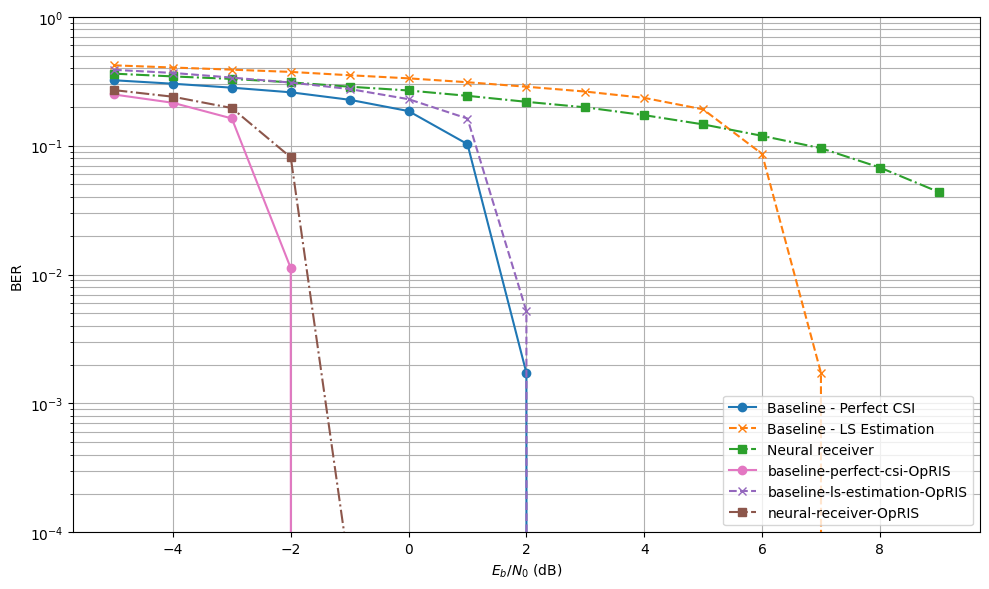

In [121]:
plt.figure(figsize=(10,6))
# Baseline - Perfect CSI
plt.semilogy(ebno_dbs, BER['baseline-perfect-csi'], 'o-', c=f'C0', label=f'Baseline - Perfect CSI')
# Baseline - LS Estimation
plt.semilogy(ebno_dbs, BER['baseline-ls-estimation'], 'x--', c=f'C1', label=f'Baseline - LS Estimation')
# Neural receiver
plt.semilogy(ebno_dbs, BER['neural-receiver'], 's-.', c=f'C2', label=f'Neural receiver')

plt.semilogy(ebno_dbs, BER['baseline-perfect-csi-OpRIS'], 'o-', c=f'C6', label=f'baseline-perfect-csi-OpRIS')
# Baseline - LS Estimation
plt.semilogy(ebno_dbs, BER['baseline-ls-estimation-OpRIS'], 'x--', c=f'C4', label=f'baseline-ls-estimation-OpRIS')
# Neural receiver
plt.semilogy(ebno_dbs, BER['neural-receiver-OpRIS'], 's-.', c=f'C5', label=f'neural-receiver-OpRIS')
#
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()